In [16]:
from IPython.display import clear_output
#!pip install anchor-exp
#!pip install pandas
#!pip install -U scikit-learn

In [17]:
from __future__ import print_function
import numpy as np
import pandas as pd
np.random.seed(1)
import sys
import sklearn
import sklearn.ensemble
%reload_ext autoreload
%autoreload 2
from anchor import utils
from anchor import anchor_tabular
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

In [18]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '50k']
train_data = pd.read_csv("datasets/adult/adult.data", header=0, names=col_names, index_col=False)
train_data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50k
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [19]:
# Missing values in data
print("Missing values in train:")
print(train_data.isnull().sum())

# Quantile based discretization with pandas qcut
train_data_clean1 = train_data.iloc[0:200].copy()
train_data_clean1['age'] = pd.qcut(train_data_clean1['age'], 8)
train_data_clean1['fnlwgt'] = pd.qcut(train_data_clean1['fnlwgt'], 8)
train_data_clean1['education-num'] = pd.qcut(train_data_clean1['education-num'], 8, duplicates='drop')
train_data_clean1['capital-gain'] = pd.qcut(train_data_clean1['capital-gain'], 8, duplicates='drop')
train_data_clean1['capital-loss'] = pd.qcut(train_data_clean1['capital-loss'], 8, duplicates='drop')
train_data_clean1['hours-per-week'] = pd.qcut(train_data_clean1['hours-per-week'], 8, duplicates='drop')

y = train_data_clean1['50k']
print(y)
class_0 = y[0]
class_1 = y[99]
print(class_0, class_1)

y = y.replace({class_0: 0, class_1: 1})
print(y)
train_data_clean1 = train_data_clean1.drop(columns=['50k'])

oh_enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
X = oh_enc.fit_transform(train_data_clean1).todok()
# !pip intall -U scikit-learn
feature_names = oh_enc.get_feature_names_out(train_data_clean1.columns)
#feature_names = col_names
t_X = X.transpose().toarray()
print(feature_names)

print(X.shape)

Missing values in train:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
50k               0
dtype: int64
0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
        ...  
195     <=50K
196      >50K
197      >50K
198     <=50K
199     <=50K
Name: 50k, Length: 200, dtype: object
 <=50K  >50K
0      0
1      0
2      0
3      0
4      0
      ..
195    0
196    1
197    1
198    0
199    0
Name: 50k, Length: 200, dtype: int64
['age_(16.999, 23.0]' 'age_(23.0, 28.0]' 'age_(28.0, 31.0]'
 'age_(31.0, 37.0]' 'age_(37.0, 41.375]' 'age_(41.375, 47.0]'
 'age_(47.0, 53.0]' 'age_(53.0, 79.0]' 'workclass_ ?'
 'workclass_ Federal-gov' 'workclass_ Local-gov' 'workclass_ Private'
 'workclass_ Self-emp-inc' 'workclass_ Self-emp-not-inc'
 'workclass_ State

In [20]:
# Arg gen

instances_by_feature = {}

for i, col in enumerate(t_X):
    instances_by_feature.update({i: list(np.where(col)[0])})

#print(instances_by_feature)

# Coverage
covi_by_arg = dict()
covc_by_arg = dict()

def generate_args_lenN(n, ibyf, dataset, predictions, minimals=None):
    """
    Generates arguments of length n, given arguments of length 1.. n-1
    :param n: length of arguments to be generated
    :param ibyf: instances_by_feature
    :param predictions:
    :param minimals: arguments (minimal)
    :return:
    """

    def is_minimal(potential_arg, cl, minimals, n):
        # cl is class
        set_potential_arg = set(potential_arg)
        for k in range(n):
            for comb_ in combinations(potential_arg, k+1):
                if frozenset(comb_) in minimals[cl][k]:
                    return False
        return True

    if minimals is None:
        minimals = ([], [])
    assert len(minimals[0]) == n-1
    minimals[0].append(set())
    minimals[1].append(set())

    args = [set(), set()]
    potential_args_checked_count = 0
    for i, row in enumerate(dataset):
        for potential_arg in combinations(np.where(row)[0], n):
            cl = predictions[i]
            potential_args_checked_count += 1
            if not is_minimal(potential_arg, cl, minimals, n-1):
                continue
            selection = set.intersection(*[set(ibyf[w]) for w in potential_arg])  # all rows with all features of potential argument
            selection_preds = [predictions[i_] for i_ in selection]
            if selection_preds[:-1] == selection_preds[1:]:
                    args[selection_preds[0]].add(frozenset(potential_arg))
                    covi_by_arg.update({frozenset(potential_arg): selection}) #covi
                    minimals[cl][n-1].add(frozenset(potential_arg))
                    covc_by_arg.update({frozenset(potential_arg): set(selection_preds)}) #covc
    print(potential_args_checked_count, ' potential arg checked.')
    return args, minimals

  

def read_args(minimals, feature_names):
    arguments = [[], []]
    for cl in range(len(minimals)):
        for a in range(len(minimals[cl])):
            for f in minimals[cl][a]:
                arguments[cl].append(tuple([feature_names[k] for k in f]))
    return arguments

In [21]:
n = 0
minimals = None
print("len ", n, ":", minimals)
compute = True
if compute:
    while not minimals or len(minimals[0][-1]) != 0 or len(minimals[1][-1]) != 0:
        n += 1
        args, minimals = generate_args_lenN(n, instances_by_feature, X.toarray(), y, minimals)
        print("len ", n, ":", len(minimals[0]))

len  0 : None
2800  potential arg checked.
len  1 : 1
18200  potential arg checked.
len  2 : 2
72800  potential arg checked.
len  3 : 3
200200  potential arg checked.
len  4 : 4
400400  potential arg checked.
len  5 : 5
600600  potential arg checked.
len  6 : 6
686400  potential arg checked.
len  7 : 7


In [22]:
name_pre = 'adult_0-200_'

if compute:
    ## Save
    pd.to_pickle(minimals, name_pre + 'minimals.df')
    ### Cov
    pd.to_pickle(covi_by_arg, name_pre + 'covibyarg.df')
    pd.to_pickle(covc_by_arg, name_pre + 'covcbyarg.df')
else: 
    ## Load
    minimals = pd.read_pickle('adult_0-100_minimals.df')
    covi_by_arg = pd.read_pickle(name_pre + 'covibyarg.df')
    covc_by_arg = pd.read_pickle(name_pre + 'covcbyarg.df')


In [23]:
# /!pip install pydot networkx

In [24]:
from os import path
import networkx as nx
import pydot
import matplotlib.pyplot as plt

def consistent(arg1, arg2, col_p_features):
    for f1, f2 in zip(list(arg1), list(arg2)):
        if f1 != f2 and col_p_feature[f1] == col_p_feature[f2]:
            return False
    return True

def build_r_atk(minimals, col_p_feature, output_path=''):
    R_atk = []
    for cl in range(2):
        for l in range(len(minimals[cl])):
            for h1 in minimals[cl][l]:
                for l2 in range(l-1):
                    for h2 in minimals[1-cl][l2]:
                        if consistent(h1, h2, col_p_feature):
                            R_atk.append((h1, h2))

    pd.to_pickle(R_atk, path.join(output_path, 'R_atk_rt2_dev.df'))


def evaluate_r_atk(minimals, col_p_feature, input_path=''):
    build_r_atk(minimals, col_p_feature, input_path)
    R_atk = pd.read_pickle(path.join(input_path, 'R_atk_rt2_dev.df'))
    print('len', len(R_atk))

    G = nx.Graph()
    G.add_edges_from(R_atk)
    #G = nx.petersen_graph()
    nx.draw(G, with_labels=True, font_weight='bold')
    nx.drawing.nx_pydot.write_dot(G, "R_atk_fig.dot")
    plt.savefig("R_atk_fig.png")
    return G

{'age': {0, 1, 2, 3, 4, 5, 6, 7, 51}, 'workclass': {8, 9, 10, 11, 12, 13, 14}, 'fnlwgt': {15, 16, 17, 18, 19, 20, 21, 22}, 'education': {32, 33, 34, 35, 36, 37, 38, 39, 40, 23, 24, 25, 26, 27, 28, 29, 30, 31}, 'education-num': {40, 37, 38, 39}, 'marital-status': {41, 42, 43, 44, 45, 46, 47}, 'occupation': {48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}, 'relationship': {64, 65, 66, 61, 62, 63}, 'race': {67, 68, 69, 70, 71}, 'sex': {72, 73}, 'capital-gain': {74}, 'capital-loss': {75}, 'hours-per-week': {76, 77, 78, 79, 80}, 'native-country': {81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94}}
{0: 'age', 1: 'age', 2: 'age', 3: 'age', 4: 'age', 5: 'age', 6: 'age', 7: 'age', 51: 'occupation', 8: 'workclass', 9: 'workclass', 10: 'workclass', 11: 'workclass', 12: 'workclass', 13: 'workclass', 14: 'workclass', 15: 'fnlwgt', 16: 'fnlwgt', 17: 'fnlwgt', 18: 'fnlwgt', 19: 'fnlwgt', 20: 'fnlwgt', 21: 'fnlwgt', 22: 'fnlwgt', 23: 'education', 24: 'education', 25: 'education', 26: 'educat

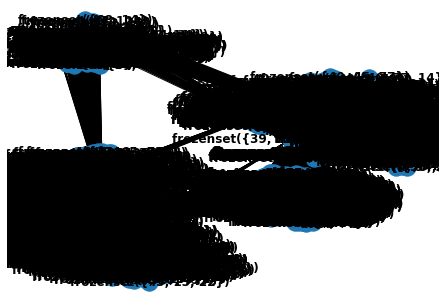

In [25]:
# Building Attack graph

features_p_col = {}
col_p_feature = {}

for col in train_data_clean1.columns:
    features_p_col[col] = set()
    for i, f in enumerate(feature_names):
        if col in f:
            features_p_col[col].add(i)
            col_p_feature[i] = col

print(features_p_col)
print(col_p_feature)

G = evaluate_r_atk(minimals, col_p_feature)

degs = np.array(list(G.degree()), dtype = [('node', 'object'), ('degree', int)])
degrees = np.sort(degs, order='degree')
print(degrees[-20:])

In [26]:
degrees.shape

(2392,)

In [27]:
# Building Naive extensions
input_path=''
R_atk = pd.read_pickle(path.join(input_path, 'R_atk_rt2_dev.df'))

all_args = set()
for cl in range(len(minimals)):
    for l in range(len(minimals[cl])):
          all_args.update(minimals[cl][l])

print(len(all_args), ' args in total.')

# Finding naive extensions can also be done by finding all maximal independent 
# sets: nx.maximal_independent_set(G) can output one random one.

naive_extensions = {}
for (h1, h2) in R_atk:
    if h1 not in naive_extensions:
        naive_extensions[h1] = all_args.copy()
    if h2 not in naive_extensions:
        naive_extensions[h2] = all_args.copy()
    naive_extensions[h1].discard(h2)
    naive_extensions[h2].discard(h1)

print(len(naive_extensions))

print(set.intersection(*naive_extensions.values()))

2392  args in total.
2392
set()


In [35]:
covi_by_ext = dict()
covc_by_ext = dict()
max_covi = {}
max_covi_ext = {}

for ext in naive_extensions.values():
    covi = set.union(*[covi_by_arg[arg] for arg in ext])
    covi_by_ext.update({frozenset(ext): covi})
    if len(covi) > len(max_covi):
        max_covi_ext = ext
        max_covi = covi
    covc = set.union(*[covc_by_arg[arg] for arg in ext])
    covc_by_ext.update({frozenset(ext): covc})

print(len(covi_by_ext[frozenset(max_covi_ext)]), "/", len(X))

sorted_covs = [len(cov) for cov in covi_by_ext.values()]
sorted_covs.sort()
print(sorted_covs)

#for args in combinations(covi_by_ext.values(), 2):
#    assert(args not in R_atk)
#print("Coherence check")
print("Coherence not check")

print(max_covi_ext)
print(len(covi))

200 / 2800
[143, 143, 148, 148, 149, 152, 153, 153, 157, 158, 159, 165, 167, 169, 170, 174, 175, 175, 176, 176, 177, 177, 181, 182, 183, 185, 186, 189, 189, 191, 192, 195, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200

In [36]:
def explain(instance, i, extension=max_covi_ext, covi_by_ext=covi_by_ext):
    expl = set()
    instance_set = set(np.where(instance.toarray() != 0)[1])
    if i in covi_by_ext[frozenset(extension)]:
        for arg in extension:
            if arg.issubset(instance_set):
                expl.add(arg)
    return expl

def parse_features(explanation, feature_names=feature_names):
    parsed_expl = set()
    for arg in explanation:
        parsed_expl.add(frozenset([feature_names[k] for k in arg]))
    return parsed_expl

In [37]:
empty = 0
tot = 0
for k in range(X.shape[0]):
    expl = parse_features(explain(X.getrow(k), k, max_covi_ext, covi_by_ext))
    print(k, expl)
    if not expl:
        empty += 1
    tot += 1

print(empty, tot)

0 {frozenset({'hours-per-week_(0.999, 30.0]', 'workclass_ Self-emp-not-inc'}), frozenset({'occupation_ Exec-managerial', 'education-num_(10.0, 13.0]', 'relationship_ Husband', 'age_(47.0, 53.0]'}), frozenset({'education-num_(10.0, 13.0]', 'fnlwgt_(78220.125, 114847.75]'}), frozenset({'education-num_(10.0, 13.0]', 'relationship_ Husband', 'age_(47.0, 53.0]', 'race_ White'}), frozenset({'hours-per-week_(0.999, 30.0]', 'education-num_(10.0, 13.0]'}), frozenset({'workclass_ Self-emp-not-inc', 'education_ Bachelors', 'age_(47.0, 53.0]'}), frozenset({'workclass_ Self-emp-not-inc', 'fnlwgt_(78220.125, 114847.75]'}), frozenset({'hours-per-week_(0.999, 30.0]', 'age_(47.0, 53.0]'}), frozenset({'relationship_ Husband', 'age_(47.0, 53.0]', 'education_ Bachelors'}), frozenset({'occupation_ Exec-managerial', 'hours-per-week_(0.999, 30.0]'}), frozenset({'fnlwgt_(78220.125, 114847.75]', 'education_ Bachelors'}), frozenset({'occupation_ Exec-managerial', 'education-num_(10.0, 13.0]', 'age_(47.0, 53.0]'

147 {frozenset({'age_(53.0, 79.0]', 'occupation_ Craft-repair'}), frozenset({'fnlwgt_(146930.625, 183552.5]', 'occupation_ Craft-repair'}), frozenset({'fnlwgt_(146930.625, 183552.5]', 'education-num_(1.999, 9.0]', 'sex_ Male'}), frozenset({'education-num_(1.999, 9.0]', 'workclass_ Private', 'relationship_ Husband', 'native-country_ United-States'}), frozenset({'age_(53.0, 79.0]', 'workclass_ Private', 'education-num_(1.999, 9.0]'}), frozenset({'age_(53.0, 79.0]', 'education-num_(1.999, 9.0]', 'native-country_ United-States'}), frozenset({'education-num_(1.999, 9.0]', 'workclass_ Private', 'relationship_ Husband', 'occupation_ Craft-repair'}), frozenset({'age_(53.0, 79.0]', 'fnlwgt_(146930.625, 183552.5]', 'education-num_(1.999, 9.0]'}), frozenset({'age_(53.0, 79.0]', 'fnlwgt_(146930.625, 183552.5]', 'workclass_ Private'}), frozenset({'age_(53.0, 79.0]', 'fnlwgt_(146930.625, 183552.5]', 'native-country_ United-States'}), frozenset({'marital-status_ Married-civ-spouse', 'workclass_ Priva

In [38]:
lne = list(naive_extensions.keys())
naive_extensions[frozenset({32})]

{frozenset({19, 48}),
 frozenset({86}),
 frozenset({19, 36, 61}),
 frozenset({2, 15, 79}),
 frozenset({15, 30}),
 frozenset({19, 31}),
 frozenset({21, 33, 61, 71}),
 frozenset({13, 40, 41}),
 frozenset({13, 34, 65}),
 frozenset({19, 40, 77}),
 frozenset({11, 34, 62, 79}),
 frozenset({17, 54}),
 frozenset({1, 48}),
 frozenset({5, 19, 56}),
 frozenset({41, 54}),
 frozenset({19, 33}),
 frozenset({20, 57}),
 frozenset({2, 43, 73, 79}),
 frozenset({65, 79}),
 frozenset({5, 19, 94}),
 frozenset({17, 31, 56}),
 frozenset({5, 11, 33, 62}),
 frozenset({11, 68, 94}),
 frozenset({6, 20, 41}),
 frozenset({10, 41}),
 frozenset({22, 56, 73}),
 frozenset({13, 22, 79}),
 frozenset({22, 37, 41, 62, 77}),
 frozenset({88}),
 frozenset({13, 40, 51}),
 frozenset({9, 76}),
 frozenset({5, 18, 69}),
 frozenset({38, 62}),
 frozenset({21, 41, 62}),
 frozenset({5, 39, 56}),
 frozenset({33, 41, 62, 72}),
 frozenset({62, 68}),
 frozenset({5, 9}),
 frozenset({6, 68}),
 frozenset({11, 39, 50, 61}),
 frozenset({5, 34